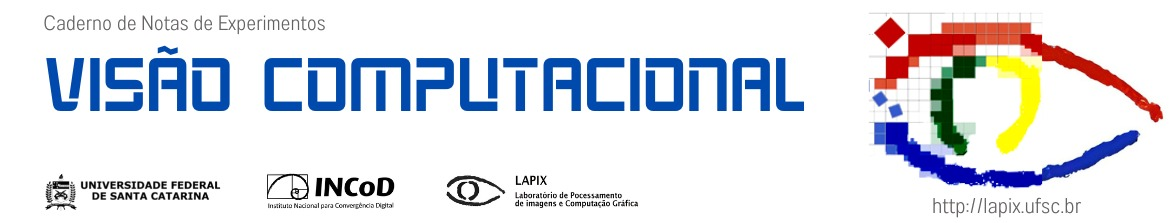

# 12.3.Classificação de Imagens com EfficientNet

No notebook anterior nós conhecemos a classificação de imagens com redes neurais convolucionais. Para tanto nós empregamos um notebook que utilizava o modelo de rede neural *ResNet - Residual Neural Network*. ResNets foram um modelo revolucionário de rede neural convolucional que introduziu o conceito do "bloco residual”, capaz de permitir que se projetasse redes neurais muito mais profundas do que até aquele momento, resolvendo de uma forma matematicamente muito elegante o problema dos “gradientes evanescentes”, que fazia com que em redes neurais muito profundas a propagação do erro durante o aprendizado se diluísse até o ponto em que fatores como erros de arredondamento e ruído acabavam anulando o efeito de aprendizado. Os blocos residuais tornaram desnecessários “acochambros” como os utilizados pela Google no modelo Inception para "injetar um sinal reforçado” pelo meio da rede neural. 

Apesar da sua excelente performance e dessas propriedades matemáticas e de elegância arquitetônica, que tornam as ResNets um modelo de didático por excelência, trata-se de um modelo publicado em dezembro de 2015. A luz da velocidade com que a tecnologia de aprendizado profundo evolui, isto torna esse modelo quase que "pré-histórico".

Neste notebook nós vamos retornar a tarefa de classificação de imagens, desta vez empregando o modelo de rede neural ***EfficientNet***. É um modelo muito mais moderno, publicado em maio de 2019, que propõe, além de várias estratégias para o tornar a rede neural mais compacta e eficiente, também uma sistemática para você escalar o modelo de rede neural de acordo com a complexidade do seu problema, permitindo a todo desenvolvedor criar modelos customizados sem grande esforço de pesquisa e sem muito risco de perda de qualidade dos resultados. Como são redes muito mais compactas, são indicadas para o desenvolvimento de aplicações embarcadas. O repositório de código dos autores vem com oito modelos prontos, numerados de b0 a b7, mas a estratégia proposta por eles permite facilmente você desenvolver modelos maiores ou menores.


# Autores:


* Aldo Von Wangenheim: aldo.vw@ufsc.br
* Thiago Zimmermann Loureiro Chaves: thiago.zlc@grad.ufsc.br
* Rodrigo de Paula e Silva Ribeiro: ribeiro.rodrigo@posgrad.ufsc.br


<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/12.3.Classifica%C3%A7%C3%A3o%20de%20Imagens%20EfficientNet.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-greeng" alt="Python Version" title="Python Version"></a>

# Para utilizar a placa de vídeo no Google Colab...

1) clique no ▾ do lado de "Conectar"

2) Ver recursos

3) Alterar o tipo de ambiente de execução

4) Acelerador de hardware: GPU

5) Execute a célula abaixo. Ela deve retornar as informações da placa de vídeo.

SE ESTIVER UTILIZANDO NO LAPIX DEFINIR A GPU A SER UTILIZADA NO CÓDIGO ABAIXO

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
import torch
from IPython import get_ipython
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
else:
    BASE_PATH = "/lapix" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix
    VISIBLE_GPUS = [7] # Selecionar a GPU PARA RODAR! VER QUAL ESTA LIVRE

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())
    
os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

Thu May 25 15:36:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Instalando as Bibliotecas Necessárias

---



In [ ]:
INSTALL_LIBS = False # Setar para True para instalar localmente também (Não é necessário se estiver rodando nos conteiners Lapix)

if _ON_COLAB:
    INSTALL_LIBS = True

if INSTALL_LIBS:
    !pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
from fastai.vision.all import *
from torchvision.models import *



---



# Download Dataset

---



## OPÇÃO 1: DATASET CUSTOM

Se você deseja carregar um **conjunto de dados cutomizado** seu, utilize esta célula aqui, adaptando os parâmetros para o caminho para o qual você realizou o download das suas imagens.

Observe que esta célula parte da premissa de que você **já baixou** seus dados para alguma pasta da máquina virtual do Colab, seja através da conexão com o Google Drive na célula mais acima, se através de upload manual do seu computador ou de download manual para o Colab.



In [ ]:
path = Path("Path Dataset") #Pasta base do dataset
train_path = path/'train' # subpasta com o conjunto de treinamento
valid_path = path/'val' # subpasta com o conjunto de validação
test_path = path/'test' # subpasta com o conjunto de teste

## OPÇÃO 2: DATASET Identificação de Tipo e Estado de Conservação de Caminho Navegável

**(Se você está cursando a disciplina *EEL110021 - Visão Computacional e Inteligência Artificial para Veículos Autônomos*, esta aqui é a célula pensada para as suas aulas práticas)**

Esta opção aqui carrega a versão disponível no Mendeley Data do dataset de classificação visual monocular de tipo e qualidade de paviemtno presente no ***Road Traversing Knowledge (RTK) Dataset*** (2019) - https://doi.org/10.22456/2175-2745.91522

Esse conjunto de dados contém estradas com diferentes tipos de superfície: variações de asfalto, de outros tipos de pavimento e inclusive estradas não pavimentadas. Contém também situações com danos na estrada, como por exemplo: buracos. As imagens foram capturadas em um veículo em movimento nas cidades de Águas Mornas e Santo Amaro da Imperatriz, municípios vizinhos a Florianópolis no estado de Santa Catarina, Brasil. Também disponibilizamos grande parte dos frames separados por suas classes, como dados de teste.  

Mais infos estão em:

*   Road Surface Classification - An approach for road surface type and quality classification https://towardsdatascience.com/road-surface-classification-150f9874faef
*   https://lapix.ufsc.br/pesquisas/projeto-veiculo-autonomo/datasets/
*   https://github.com/thiagortk/Road-Surface-Classification

![imagem](http://www.lapix.ufsc.br/wp-content/uploads/2019/03/circuitoAM.jpeg)

In [ ]:
import os
file_link = "https://data.mendeley.com/public-files/datasets/ffwgjdfn86/files/544006e3-1f21-47b3-944b-33316ff72d34/file_downloaded"
!wget $file_link

os.rename(os.path.join(BASE_PATH, "file_downloaded"), os.path.join(BASE_PATH, "file_downloaded.zip"))
!unzip -qq -u file_downloaded.zip
!rm -rf file_downloaded.zip

### Função auxiliar para gerar um subset com 'n' números de imagens. Neste notebook o seu propósito é em auxiliar na divisão dos conjuntos de treino, teste e validação.


In [ ]:
### Função auxiliar para gerar um subset com 'n' números de imagens. Neste notebook o seu propósito é em auxiliar na divisão dos conjuntos de treino, teste e validação.
import shutil
import random
def random_sample_images(dirpath, destfolder, nimages):
  files_list = os.listdir(dirpath)
  for filename in random.sample(files_list, nimages):
    shutil.move(os.path.join(dirpath, filename), os.path.join(destfolder, filename))

### Criar os diretórios onde os dados estarão de acordo com o formato esperado e realizar a separação nos conjuntos de treino, teste e validação com sua devida proporção e para seus diretórios previamente criados.


In [ ]:
### Criar os diretórios onde os dados estarão de acordo com o formato esperado e realizar a separação nos conjuntos de treino, teste e validação com sua devida proporção e para seus diretórios previamente criados.
PATH_DATASET = os.path.join(BASE_PATH, "dataset")
PATH_TRAIN = os.path.join(PATH_DATASET, "train")
PATH_VAL = os.path.join(PATH_DATASET, "val")
PATH_TEST = os.path.join(PATH_DATASET, "test")
os.makedirs(PATH_DATASET, exist_ok=True)
os.makedirs(PATH_TRAIN, exist_ok=True)
os.makedirs(PATH_VAL, exist_ok=True)
os.makedirs(PATH_TEST, exist_ok=True)
os.chdir(os.path.join(BASE_PATH, "RoadQualityClassification"))
dirnames = os.listdir('.')
datadict = {}
for dir_name in dirnames:
  os.makedirs(os.path.join(PATH_TRAIN,dir_name), exist_ok=True)
  os.makedirs(os.path.join(PATH_VAL,dir_name), exist_ok=True)
  os.makedirs(os.path.join(PATH_TEST,dir_name), exist_ok=True)
  datadict[dir_name] = len([fname for fname in os.listdir(os.path.join(dir_name,'.')) if os.path.isfile(os.path.join(dir_name,fname))])

train_rate = 0.8 # proporção dos arquivos que serão utilizados para treino - 80%
val_rate = 0.1 # proporção dos arquivos que serão utilizados para validação - 10%
test_rate = 0.1 # proporção dos arquivos que serão utilizados para teste - 10%
for key in datadict:
  images_to_train = int(datadict[key] * train_rate)
  images_to_val = int(datadict[key] * val_rate)
  images_to_test = int(datadict[key] * test_rate)
  random_sample_images(key, os.path.join(PATH_TRAIN, key), images_to_train)
  random_sample_images(key, os.path.join(PATH_VAL, key), images_to_val)
  random_sample_images(key, os.path.join(PATH_TEST, key), images_to_test)
os.chdir(BASE_PATH)



### Definir o caminho base do conjunto de dados, batch e input size da rede


In [ ]:
### Definir o caminho base do conjunto de dados, batch e input size da rede
from pathlib import Path
path_dataset = Path(PATH_DATASET)
train_path = os.path.join(path_dataset, 'train')
valid_path = os.path.join(path_dataset, 'val')
test_path = os.path.join(path_dataset, 'test')
size = 512 # resize das imagens deste dataset para a rede
batch_size = 8 # batch size deste dataset

## OPÇÃO 3: DATASET MINDFUNGA

**(Se você está cursando as disciplinas *INE410121 - Visão Computacional ou INE5443 - Reconhecimento de Padrões*, esta aqui é a célula pensada para as suas aulas práticas)**

MIND.Funga é um projeto de Ciência Cidadã da UFSC e da UFMG que objetiva responder perguntas científicas que nos levam a desenvolver pesquisas de curto e longo prazo, especialmente em áreas pouco exploradas e ameaçadas. Para tanto, usamos uma abordagem integrativa (taxonomia, filogenia molecular, ecologia, metagenômica e etc.) em nossos estudos com macro e microfungos. Saiba mais em https://mindfunga.ufsc.br/

![imagem](https://mindfunga.ufsc.br/files/2022/01/ebook-horizontal-1-1024x576.png)



### Realizar o download do conjunto de dados MindFunga já preparados no formato fast.ai/efficientNet e em seguida descompactá-lo.

In [ ]:
import os
os.chdir(BASE_PATH)
!gdown 1xKxLCLAk9yQ-17SVfanJ35meDeRj2ivI
!unzip 'SplittedMendeley.zip'

### Definir o caminho base do conjunto de dados, batch e input size da rede

In [ ]:
path_dataset = Path(os.path.join(BASE_PATH,"content/gdrive/Shareddrives/MindFunga/SplittedMendeleyDataset"))
train_path = os.path.join(path_dataset, 'train')
valid_path = os.path.join(path_dataset, 'val')
test_path = os.path.join(path_dataset, 'test')
size = 512 # resize das imagens deste dataset para a rede
batch_size = 8 # batch size deste dataset

# Criar o dataloader

In [ ]:
data = ImageDataLoaders.from_folder(
    path_dataset, train='train', valid='val', test='test',
    item_tfms=Resize(size),
    batch_tfms=[*aug_transforms(size=size), Normalize.from_stats(*imagenet_stats)],
    bs=batch_size,
    num_workers=0
)

# Escolha seu modelo de EfficientNet
---

EfficientNet é uma arquitetura de rede neural convolucional que dimensiona uniformemente profundidade/largura/resolução usando um coeficiente composto. Ao contrário do que se faz convencionalmente (dimensionamento arbitrário destes fatores), o método de dimensionamento EfficientNet dimensiona uniformemente a largura, a profundidade e a resolução da rede com um conjunto de coeficientes fixos.


O método de dimensionamento composto é justificado pela intuição de que, se a imagem de entrada for maior, a rede precisa de mais camadas para aumentar o campo receptivo e mais canais para capturar padrões mais refinados na imagem maior. A "rede base" *EfficientNet-B0* é baseada nos blocos residuais de gargalo invertidos do MobileNetV2.

Neste contexto, os autores projetaram as EfficientNets, que alcançam precisão e eficiência muito melhores do que as ConvNets anteriores. Em particular, a EfficientNet-B7 atinge 84,3% de precisão top-1 de última geração no ImageNet, sendo **8,4x menor e 6,1x mais rápido** na inferência do que o melhor ConvNet existente.

As EfficientNets também transferem bem e alcançam precisão de última geração em CIFAR-100 (91,7%), Flowers (98,8%) e 3 outros conjuntos de dados de aprendizado de transferência, com uma ordem de magnitude a menos de parâmetros [1].

![imagem](https://1.bp.blogspot.com/-Cdtb97FtgdA/XO3BHsB7oEI/AAAAAAAAEKE/bmtkonwgs8cmWyI5esVo8wJPnhPLQ5bGQCLcBGAs/s1600/image4.png)

Modelos Disponíveis:


*   efficientnet_b0
*   efficientnet_b1
*   efficientnet_b2
*   efficientnet_b3
*   efficientnet_b4
*   efficientnet_b5
*   efficientnet_b6
*   efficientnet_b7

In [ ]:
from fastai.vision.models import efficientnet_b0
arch = efficientnet_b0(weights=True)
model = nn.Sequential(arch, nn.Linear(in_features=1000, out_features=data.c, bias=True))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth
100%|██████████| 255M/255M [00:03<00:00, 74.1MB/s]


# Definindo Learner

---



In [ ]:
# Define learner
learn = Learner(
    dls=data,
    model=arch,
    metrics=[accuracy, top_k_accuracy],
    opt_func=Adam,
    loss_func=LabelSmoothingCrossEntropy()
)

# Treinando o Modelo

---



## Treinamos utilizando a política de adaptação simultânea de taxa de aprendizado e momento linear da rede para superconvergência 1cycle

Abaixo um explicação retirada de nosso tutorial "How to resume an interrupted training session in fastai" disponível em: https://towardsdatascience.com/how-to-resume-an-interrupted-training-session-in-fastai-77c4f36cd3a1

O método fit_one_cycle() empregado pelo fast.ai funciona com taxas e momentos de aprendizado variados e adaptativos, seguindo uma curva em que a taxa é aumentada e depois diminuída, enquanto o momento é tratado de forma oposta, conforme mostrado na figura abaixo.

![imagem](https://miro.medium.com/max/720/1*38YBWIKFwXN0YlNOVo_LOA.jpeg)

Se você interromper um treino na epoch #10 de, digamos, 20 epochs e depois recomeçar por mais 9 epochs, você não terá o mesmo resultado de treinar ininterruptamente por 20 epochs, porque um novo treino do zero, mesmo que você carregue os pesos da última época, empregarão uma nova taxa de aprendizado e política de impulso e passarão pelo ciclo novamente.

O que você quer é começar de onde você foi interrompido no ciclo.

![imagem](https://miro.medium.com/max/720/0*AzuB9-kayY2Abfp3.png)

### O que é fit1cycle?

Fit1cycle é uma política de superconvergência desenvolvida por Leslie N. Smith. Está disponível como a política de treinamento preferida no fast.ai. Veja abaixo os detalhes:

* https://docs.fast.ai/callbacks.one_cycle.html
* A disciplined approach to neural network hyper-parameters: Part 1 — learning rate, batch size, momentum, and weight decay — https://arxiv.org/abs/1803.09820
* Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates — https://arxiv.org/abs/1708.07120

Se você quiser ver mais artigos, siga este link: Papers de Leslie N. Smith. Não entraremos em detalhes nesta postagem. Existem várias postagens no Medium apresentando e discutindo a política de treinamento fit1cycle de uma maneira fácil de ler:

* Training Neural Networks upto 10x Faster by Karanbir Chahal;
* SuperConvergence with inbuilt regularization by Yogesh Gurjar;
* Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates by Aditya Gupta;
* Fast.ai Part1 v2/v3 Notes — Learning Rates — from SGDR to 1cycle and Super-Convergence by Roger Mao;
* Reproducing Leslie N. Smith’s papers using fastai by Kushajveer Singh.

Esta última postagem de Kushajveer Singh tem um notebook Jupyter muito ilustrativo que vale a pena olhar. Há também um artigo muito interessante de Nachiket Tanksale chamado Finding Good Learning Rate e The One Cycle Policy, onde as taxas de aprendizado cíclico e o momento são discutidos.

Leia o nosso tutorial para saber mais sobre treino em etapas e 1cycle.

In [ ]:
TRAIN_EPOCH = 1
learn.fit_one_cycle(TRAIN_EPOCH, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.487012,2.840788,0.595898,0.778741,2:58:52
1,3.416472,4.846232,0.496823,0.724726,46:33
2,3.584479,5.348385,0.464471,0.673021,46:23
3,3.399767,6.101927,0.517331,0.739746,46:23
4,3.066022,6.409873,0.544772,0.744945,46:26


In [ ]:
# Evaluate model on validation set
interp = ClassificationInterpretation.from_learner(learn)

# Display best 5 and worst 5 results
interp.plot_top_losses(5, figsize=(20,20))
interp.plot_top_losses(5, largest=False, figsize=(20,20))

# Display heatmap of accuracy for each class
interp.plot_confusion_matrix(figsize=(12, 12), cmap='Blues')

# Salvando Modelo

---



In [ ]:
learn.save("PATH_QUE_DESEJA_SALVAR/NOME_DO_MODELO")

Path('/content/gdrive/Shareddrives/MindFunga/SplittedMendeleyV3/models/EfficientnetB4-MindFungaApp2023.pth')

# Exemplo de Formatação do Dataset (MindFunga)


---



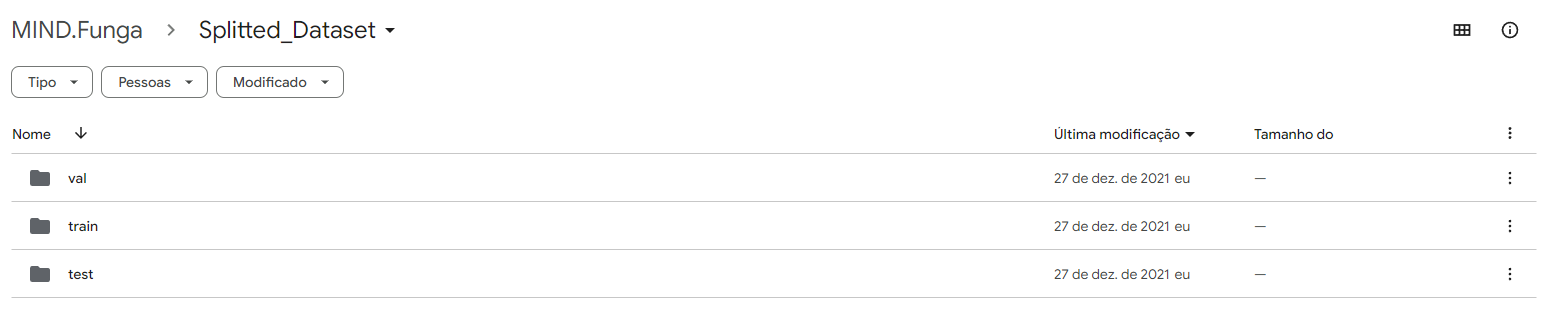

Os dados são separados por pastas, onde cada uma é uma classe

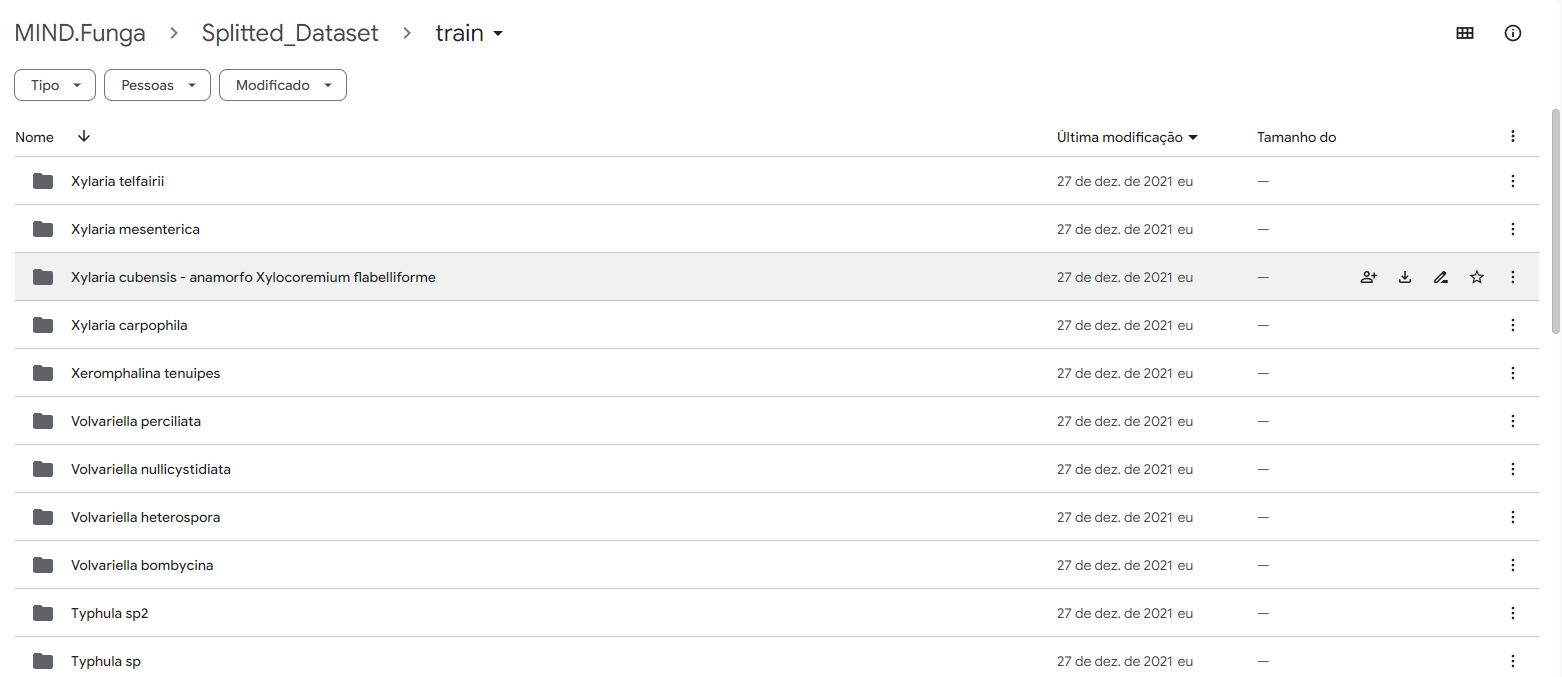